# CS 109A - Intro to Data Science: Project (WIP)
## Predicting Loan Outcomes
## Group: Andrew Greene and David Modjeska
### Harvard University, Fall 2016

In [95]:
import itertools as it
import matplotlib
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import scipy as sp
import sklearn.preprocessing as Preprocessing
import datetime

from itertools import combinations
from sklearn.cross_validation import KFold
from sklearn.decomposition import TruncatedSVD as tSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import AdaBoostClassifier as Boost
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from scipy.io import mmread
from zipfile import ZipFile

%matplotlib inline
plt.style.use('ggplot') 
from IPython.display import display, HTML

In [96]:
### specify processed data files to generate - full/partial, partial %, and train/test
### Note: this cell is present in both notebooks

# load and clean full dataset?
load_full = False

# if not loading and cleaning full dataset, what sample percentage?
sample_percent = 10

if load_full:
    pct_str = ""
else: # not load_full
    pct_str = str(sample_percent) + "_pct"
    
# use training or testing data to generate minor files?
minor_use_train = True
if minor_use_train:
    mode_str = "train"
else: # not minor_use_train
    mode_str = "test"
    
### set intermediate file names
dir_str = "./intermediate_files/"

processed_data_train_file = dir_str + "processed_data_" + "train" + pct_str + ".json"
processed_data_test_file = dir_str + "processed_data_" + "test" + pct_str + ".json"

nlp_data_file = dir_str + "nlp_data_" + mode_str + pct_str + ".json"
term_freqs_file = dir_str + "term_freqs_" + mode_str + pct_str + ".mtx"
diff_terms_file = dir_str + "diff_terms_" + mode_str + pct_str + ".json"

In [97]:
### load processed data

if load_full:
    data_zipfile = zipfile.ZipFile(processed_data_train_file + ".zip")
    data = pd.read_json(data_zipfile.open(data_zipfile.namelist()[0], 'r'))
else: # not load_full
    data = pd.read_json(processed_data_train_file)

data_nlp = pd.read_json(nlp_data_file)
desc_matrix_coo = mmread(term_freqs_file)
desc_matrix = sp.sparse.csr_matrix(desc_matrix_coo)
count_cols_df = pd.read_json(diff_terms_file)

count_cols_bool = count_cols_df.values > 0.0

In [98]:
x = data.drop('loan_status', 1)
y = data['loan_status']

x_nlp = data_nlp.drop('loan_status', 1)
y_nlp = data_nlp['loan_status']

## Step 2: Explore Data

In [99]:
image_counter = 0

In [100]:
def good_bad_quantile_plot(data, column):
    global image_counter
    
    col_data = data[column]
    nulls = pd.isnull(col_data)
    col_data = col_data[~nulls]
    #if col_data.dtype == '<M8[ns]':
    #    col_data = col_data.dt.strftime('%Y-%m')
    
    defaults = data['loan_status'] == True  # for now TODO

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # 45-degree line
    ax.plot(
        [min(col_data), max(col_data)],
        [min(col_data), max(col_data)],
        c='k'
    )
    # Actual qq plot
    ax.plot(
        list(col_data[~defaults].quantile(q=np.arange(0.0, 1.005, .005))),
        list(col_data[defaults].quantile(q=np.arange(0.0, 1.0005, .005))),
        c='r'
    )
    ax.scatter(
        list(col_data[~defaults].quantile(q=np.arange(0.0, 1.1, .1))),
        list(col_data[defaults].quantile(q=np.arange(0.0, 1.1, .1))),
        c='r'
    )
    
    ax.set_title("QQ plot for " + column)
    ax.set_xlabel('Good loans')
    ax.set_ylabel('Bad loans')
    
    plt.show()
    
    fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
    image_counter += 1

In [101]:
# print dataset shape, and widen pandas dataframe display
n, p = data.shape
pd.set_option('display.max_columns', p)

print
print "The shape of the data is", data.shape
print


The shape of the data is (17720, 32)



In [102]:
# display top rows of data set
print
data.head()

,address_state,annual_income,cpi,delinq_2_yrs,desc_len,description,dti,earliest_credit,employ_length,employ_title,gdp,home_owner,id,initial_list_status,inquiry_6_mos,installment,interest_rate,ipr,issue_date,loan_amount,loan_purpose,loan_status,loan_subgrade,loan_term,months_since_last_record,open_accounts,recoveries,revol_util,rir,total_accounts,unemploy,verif_status
10,MN,"52,000",0,0,454,Borrower added on _number_/_number_/_number_...,0,2000-11-01,3,Upper Lakes Foods,1,MORTGAGE,486154,f,2,108,7,0,Feb-2010,3500,educational,False,5,36,nan,11,0,0,0,34,0,nan
100,MI,"60,000",0,0,nan,None,0,2002-11-01,5,United States Postal Service,1,OWN,481242,f,2,658,11,0,Feb-2010,20000,debt_consolidation,False,10,36,nan,10,0,0,0,25,0,nan
10000,IL,"50,500",0,0,167,Borrower added on _number_/_number_/_number_...,0,1992-12-01,4,"BridgeNet Solutions, Inc",1,RENT,1064853,f,0,368,7,0,Jan-2012,12000,credit_card,False,5,36,nan,6,0,0,0,7,0,nan
10002,GA,"42,000",0,0,nan,None,0,1982-03-01,10,The Silver Moon,1,RENT,1159019,f,3,744,17,0,Mar-2012,20800,credit_card,False,20,36,nan,4,0,0,0,9,0,nan
10004,MI,"52,000",0,1,614,Borrower added on _number_/_number_/_number_...,0,1999-08-01,3,heartland home care,1,MORTGAGE,1128958,f,2,224,7,0,Feb-2012,7300,debt_consolidation,True,5,36,nan,16,10,0,0,29,0,nan


In [103]:
# summarize data set
print
data.describe()

,annual_income,cpi,delinq_2_yrs,desc_len,dti,gdp,id,inquiry_6_mos,installment,interest_rate,ipr,loan_amount,loan_subgrade,loan_term,months_since_last_record,open_accounts,recoveries,revol_util,rir,total_accounts,unemploy,verif_status
count,"17,720","17,720","17,720","6,138","17,720","17,720","17,720","17,720","17,720","17,720","17,720","17,720","17,720","17,720","2,201","17,720","17,720","17,720","17,720","17,720","17,720",0
mean,"73,277",0,0,292,0,1,"12,277,724",1,421,14,0,"13,646",14,41,77,11,156,0,0,25,0,nan
std,"65,866",0,1,315,0,0,"14,648,437",1,249,4,0,"8,224",7,10,28,5,738,0,0,12,0,nan
min,"4,800",0,0,1,0,1,"54,734",0,20,5,0,"1,000",5,36,0,1,0,0,0,3,0,nan
25%,"45,000",0,0,nan,0,1,"1,467,673",0,241,11,0,"7,475",10,36,nan,7,0,0,0,16,0,nan
50%,"62,000",0,0,nan,0,1,"6,320,320",1,365,13,0,"12,000",15,36,nan,10,0,0,0,23,0,nan
75%,"88,000",0,0,nan,0,1,"16,584,797",1,551,16,0,"18,500",20,36,nan,14,0,0,0,32,0,nan
max,"6,000,000",0,2,"4,118",0,1,"68,404,574",3,"1,406",29,0,"35,000",35,60,119,56,"19,618",0,0,99,0,nan


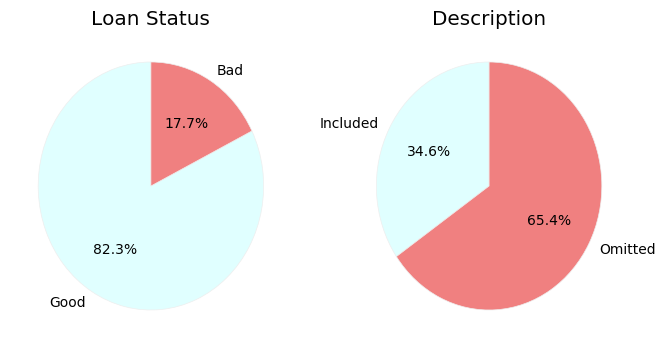

In [104]:
### plot description-related variables as pie charts
n, p = data.shape
fig = plt.figure(figsize = (8, 4))

# loan status
num_good = (data["loan_status"] == False).sum()
num_bad = n - num_good
pie_1 = fig.add_subplot(121)
pie_1.pie([num_good, num_bad], 
          labels = ["Good", "Bad"],
          colors = ["lightcyan", "lightcoral"],
         autopct = "%1.1f%%", startangle = 90)
pie_1.set_title("Loan Status")

# description included
num_include = (data["description"].notnull()).sum()
num_omit = n - num_include
pie_3 = fig.add_subplot(122)
pie_3.pie([num_include, num_omit], 
          labels = ["Included", "Omitted"],
          colors = ["lightcyan", "lightcoral"],
         autopct = "%1.1f%%", startangle = 90)
pie_3.set_title("Description")

plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

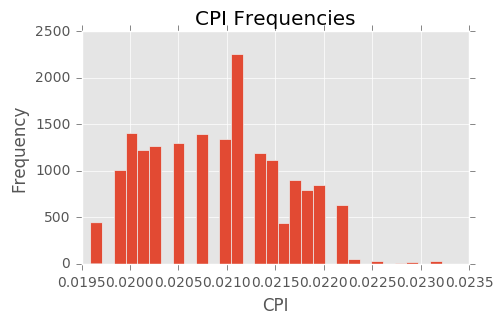

In [105]:
# plot histogram of CPI
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data['cpi'], bins = 30)
ax.set_title("CPI Frequencies")
ax.set_xlabel("CPI")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

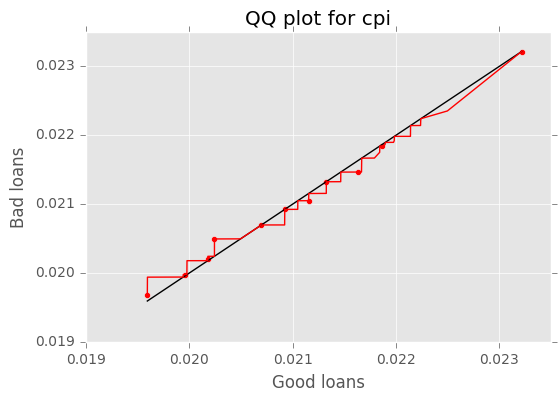

In [106]:
good_bad_quantile_plot(data, 'cpi')

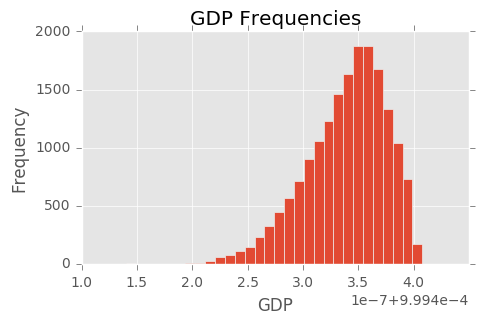

In [107]:
# plot histogram of GDP
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data['gdp'] / 1000.0, bins = 30)
ax.set_title("GDP Frequencies")
ax.set_xlabel("GDP")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

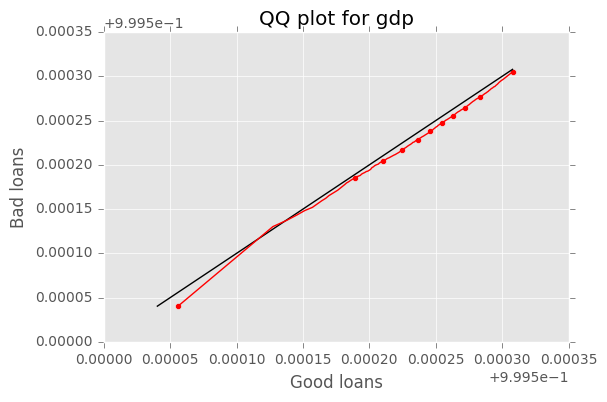

In [108]:
good_bad_quantile_plot(data, 'gdp')

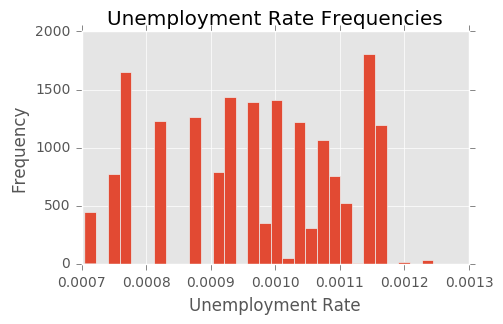

In [109]:
# plot histogram of unemployment rate
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data['unemploy'], bins = 30)
ax.set_title("Unemployment Rate Frequencies")
ax.set_xlabel("Unemployment Rate")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

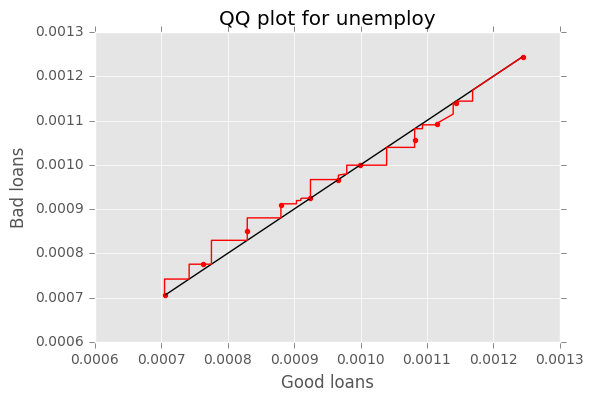

In [110]:
good_bad_quantile_plot(data, 'unemploy')

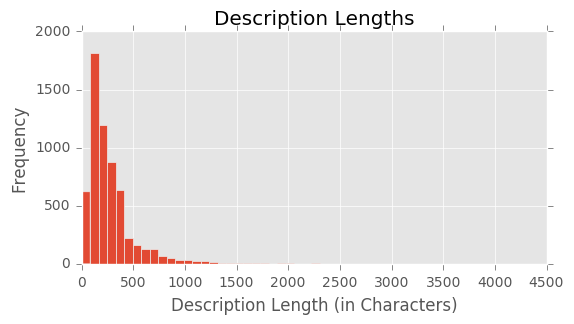

In [111]:
# visualize description lengths in characters
fig = plt.figure(figsize = (6, 3))

description_flags = data["description"].notnull()
description_lengths = data['desc_len'][description_flags]

ax1 = fig.add_subplot(111)
ax1.hist(description_lengths, bins = 50)
ax1.set_title("Description Lengths")
ax1.set_xlabel("Description Length (in Characters)")
ax1.set_ylabel("Frequency")

plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

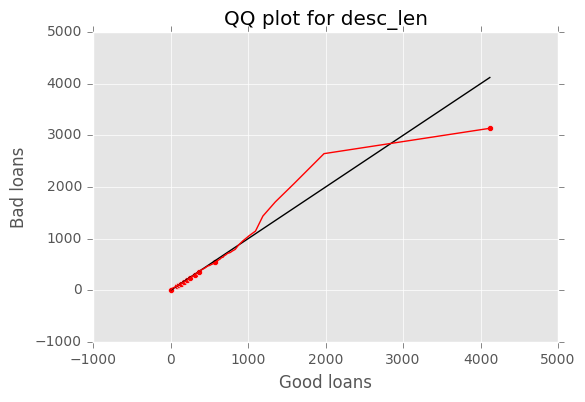

In [112]:
data_desc = data[description_flags]
good_bad_quantile_plot(data_desc, 'desc_len')

In [113]:
description_lengths_df = pd.DataFrame(description_lengths)
description_lengths_df.columns = ["description_length_chars"]
description_lengths_df.describe()

,description_length_chars
count,"6,138"
mean,292
std,315
min,1
25%,121
50%,208
75%,339
max,"4,118"


In [114]:
# Are descriptions correlated with inclusion of descriptions?
data_corr = pd.concat((data["loan_status"], description_flags), axis = 1)
corr_matrix = np.corrcoef(data_corr.T)

print
print "Loan status is not correlated with the inclusion of descriptions:\n"
print corr_matrix
print


Loan status is not correlated with the inclusion of descriptions:

[[ 1.         -0.01064286]
 [-0.01064286  1.        ]]



### Text Analysis

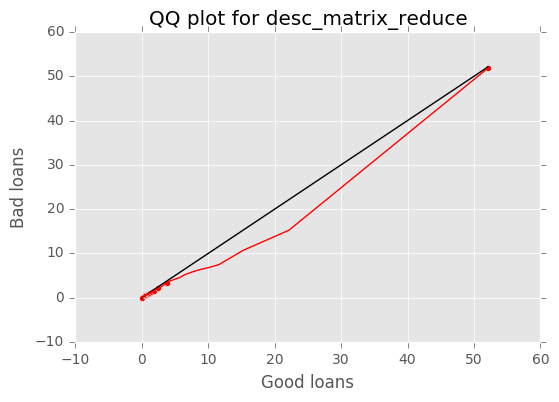

In [115]:
good_bad_quantile_plot(data_nlp, 'desc_matrix_reduce')

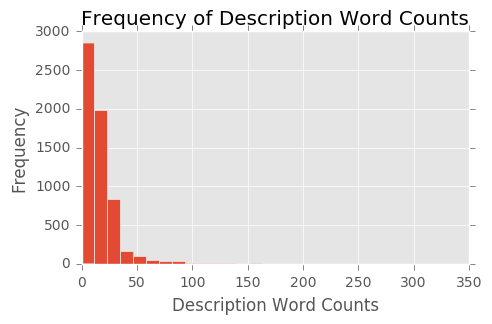

In [116]:
# plot histogram of word counts by description
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['desc_word_count'].values, bins = 30)
ax.set_title("Frequency of Description Word Counts")
ax.set_xlabel("Description Word Counts")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

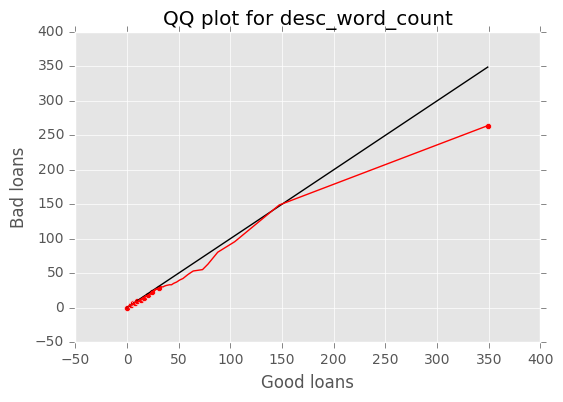

In [117]:
good_bad_quantile_plot(data_nlp, "desc_word_count")

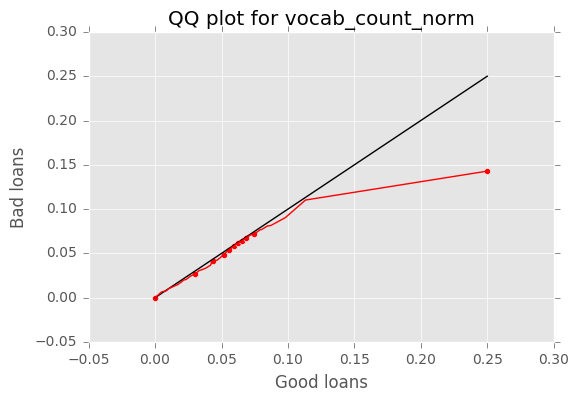

In [118]:
good_bad_quantile_plot(data_nlp, "vocab_count_norm")

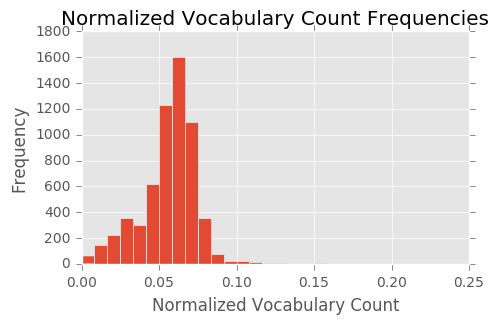

In [119]:
# plot histogram of vocabulary richness
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['vocab_count_norm'], bins = 30)
ax.set_title("Normalized Vocabulary Count Frequencies")
ax.set_xlabel("Normalized Vocabulary Count")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

In [120]:
print desc_matrix.shape

(6138, 4689)


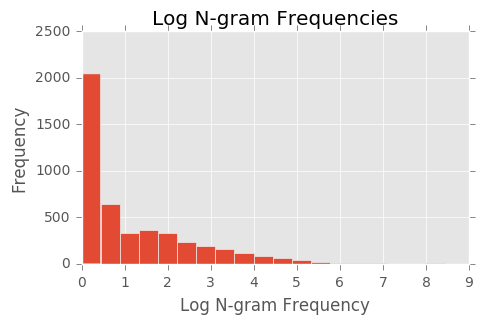

In [121]:
ngram_counts = np.log(desc_matrix.sum(axis = 0))

# plot histogram of n-gram frequency
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(ngram_counts.transpose(), bins = 20)
ax.set_title("Log N-gram Frequencies")
ax.set_xlabel("Log N-gram Frequency")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

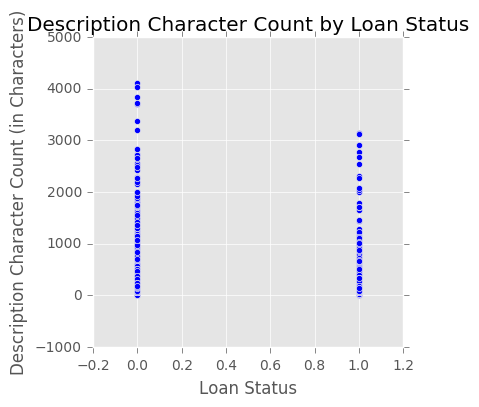

In [122]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['desc_len'])
ax1.set_title("Description Character Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Description Character Count (in Characters)")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

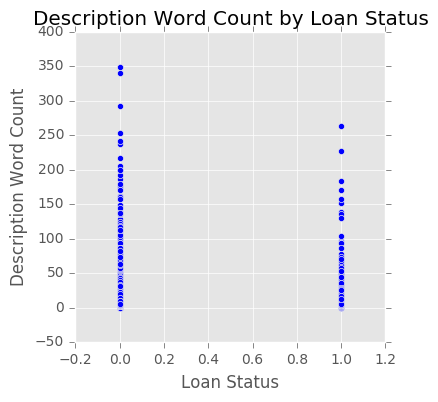

In [123]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['desc_word_count'])
ax1.set_title("Description Word Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Description Word Count")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

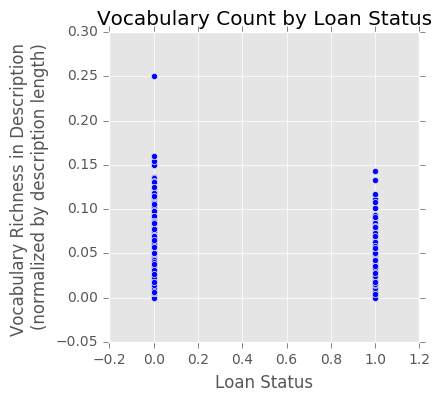

In [124]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['vocab_count_norm'])
ax1.set_title("Vocabulary Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Vocabulary Richness in Description \n(normalized by description length)")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

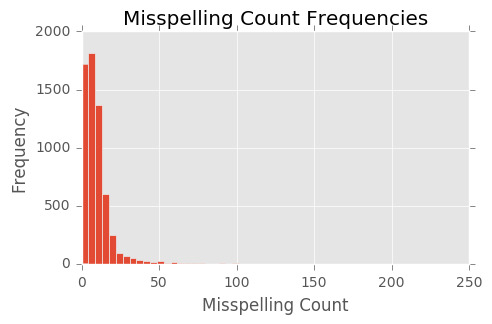

In [125]:
# plot histogram of misspelling counts
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['misspell_count'], bins = 50)
ax.set_title("Misspelling Count Frequencies")
ax.set_xlabel("Misspelling Count")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

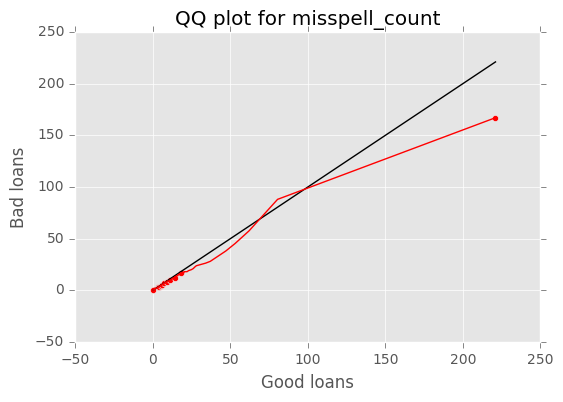

In [126]:
good_bad_quantile_plot(data_nlp, "misspell_count")

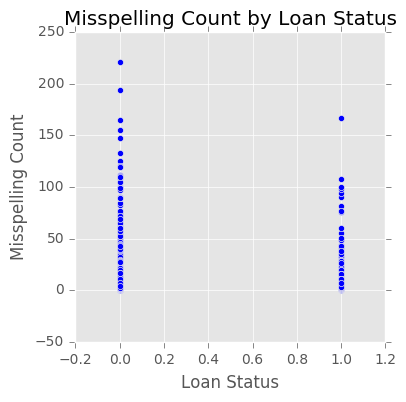

In [127]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['misspell_count'])
ax1.set_title("Misspelling Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Misspelling Count")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

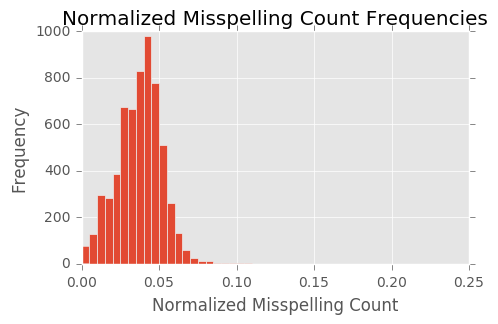

In [128]:
# plot histogram of normalized misspelling counts
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['misspell_count_norm'], bins = 50)
ax.set_title("Normalized Misspelling Count Frequencies")
ax.set_xlabel("Normalized Misspelling Count")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

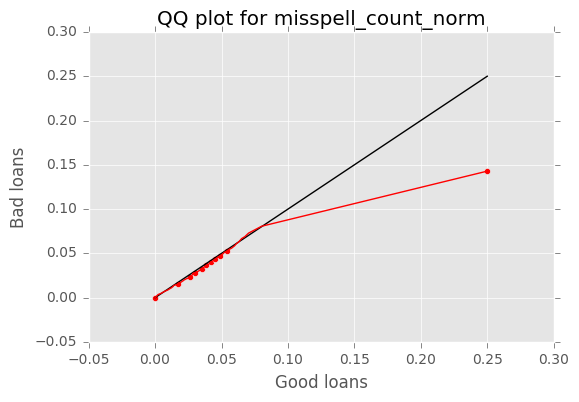

In [129]:
good_bad_quantile_plot(data_nlp, "misspell_count_norm")

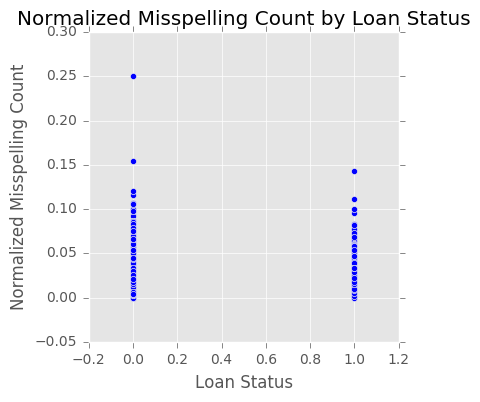

In [130]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['misspell_count_norm'])
ax1.set_title("Normalized Misspelling Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Normalized Misspelling Count")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

### Plot NLP Features

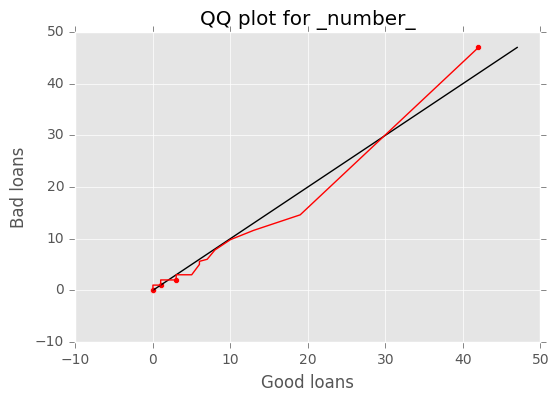

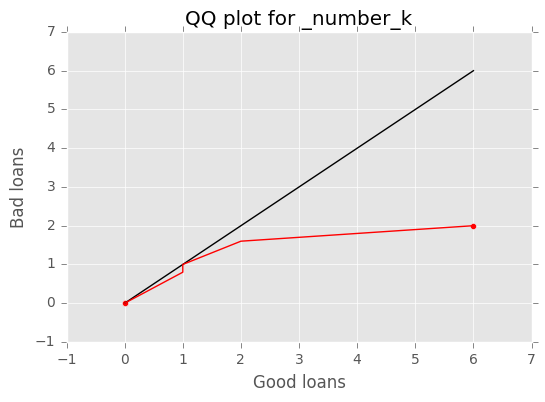

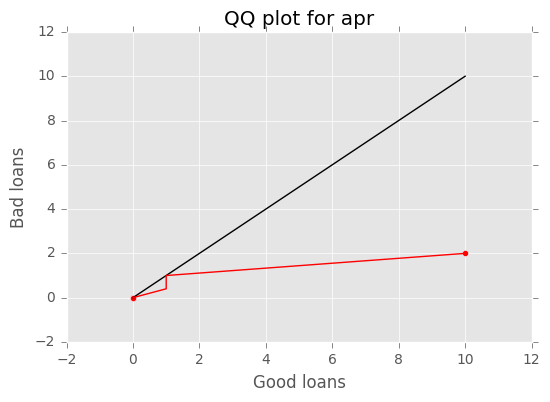

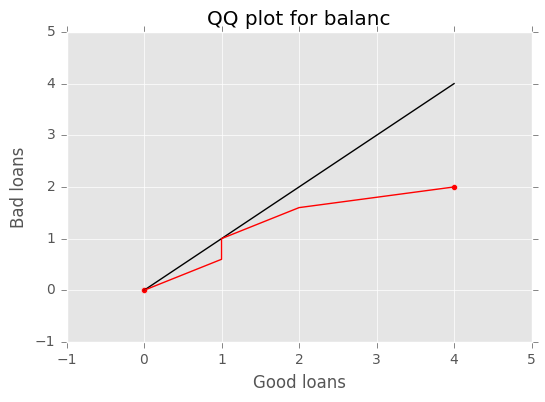

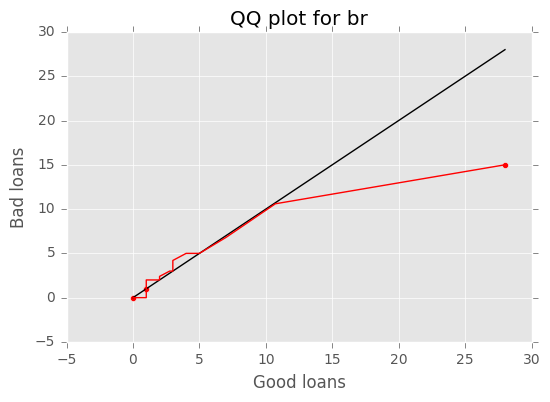

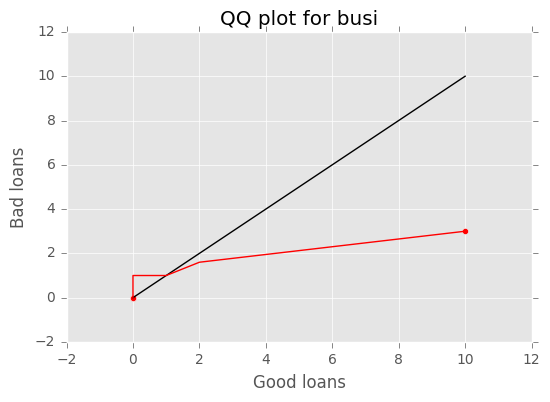

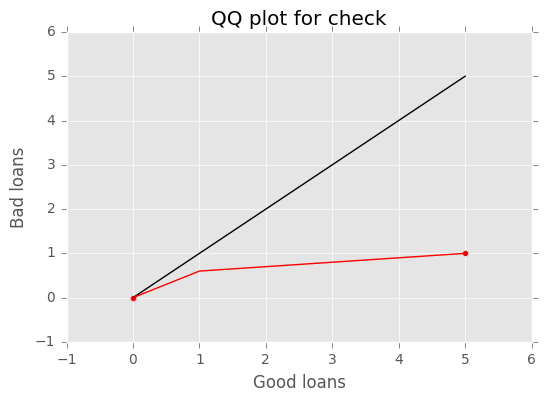

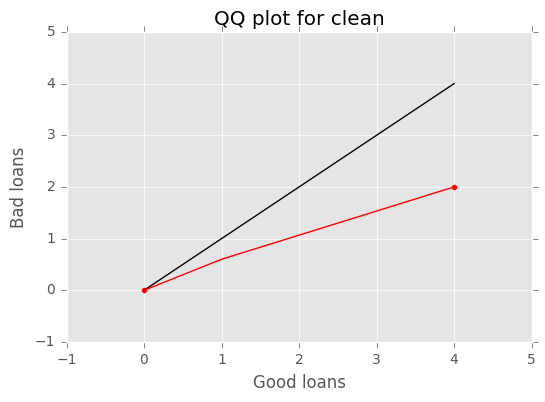

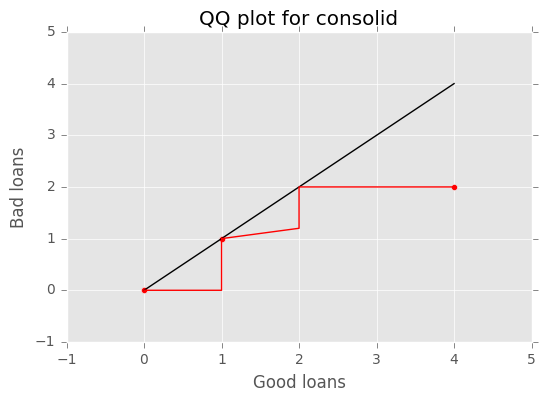

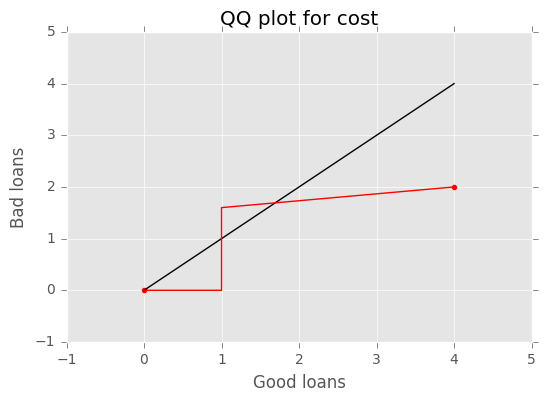

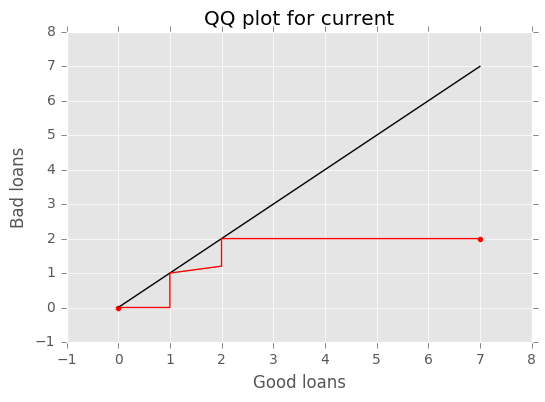

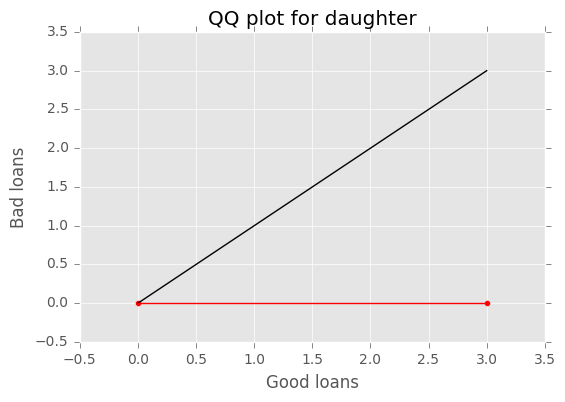

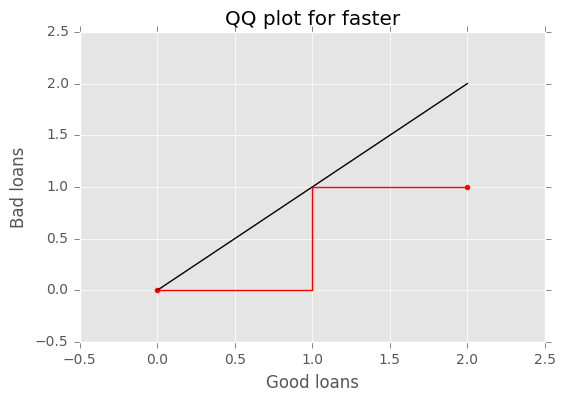

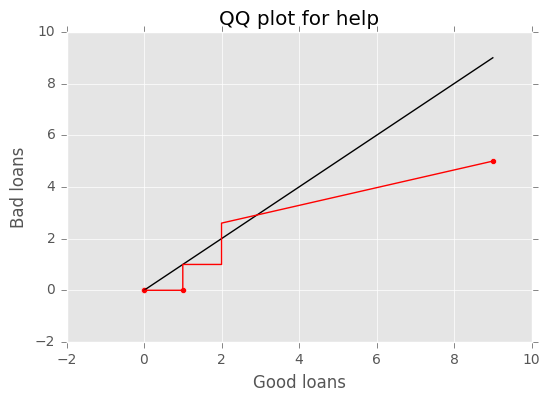

In [131]:
count_cols_qq_data = pd.concat((data_nlp['loan_status'], count_cols_df), axis = 1)
for index in range(1, count_cols_bool.shape[1] / 2):
    good_bad_quantile_plot(count_cols_qq_data, count_cols_qq_data.columns[index])

## Step 3: Model Data

In [132]:
# function to calculate expected revenue
def expected_revenue(data):
    revenue = (data['installment'] * data['loan_term']) - data['loan_amount']
    return revenue

### Baseline Models

In [133]:
# function to compute accuracy of given model on full test set, on class 0, and on class 1
score = lambda model, x_test, y_test: \
        pd.Series([model.score(x_test, y_test), 
                    model.score(x_test[y_test == 0], y_test[y_test == 0]),
                    model.score(x_test[y_test == 1], y_test[y_test == 1])],
                    index = ['Overall Accuracy', 'Accuracy on Class 0', 'Accuracy on Class 1'])

In [134]:
# function to compute revenue of given model on full test set, on class 0, and on class 1
revenue = lambda model, x, y: \
        pd.Series([model.revenue(x, y), 
                    model.revenue(x[y == 0], y[y == 0]),
                    model.revenue(x[y == 1], y[y == 1])],
                    index = ['Overall Revenue', 'Revenue for Class 0', 'Revenue for Class 1'])

In [135]:
# model that labels everything 1
class Pos_model(object):
    
    def predict(self, x):
        return np.array([1] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)
    
    def revenue(self, x, y):
        y_pred = self.predict(x)
        revenue = np.zeros(x.shape[0])
        revenue[y_pred == 0] = expected_revenue(x[y_pred == 0])
        return revenue.sum()

In [136]:
# model that labels everything 0
class Neg_model(object):
    
    def predict(self, x):
        return np.array([0] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)
    
    def revenue(self, x, y):
        y_pred = self.predict(x)
        revenue = np.zeros(x.shape[0])
        revenue[y_pred == 0] = expected_revenue(x[y_pred == 0])
        return revenue.sum()

In [137]:
# model that randomly labels things
class Random_model(object):
    
    def predict(self, x):
        return np.random.randint(0, 2, len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)
    
    def revenue(self, x, y):
        y_pred = self.predict(x)
        revenue = np.zeros(x.shape[0])
        revenue[y_pred == 0] = expected_revenue(x[y_pred == 0])
        return revenue.sum()

In [138]:
### score using baseline models

pos_model = Pos_model()
pos_model_scores = score(pos_model, x, y)
pos_model_revenues = revenue(pos_model, x, y)

neg_model = Neg_model()
neg_model_scores = score(neg_model, x, y)
neg_model_revenues = revenue(neg_model, x, y)

random_model = Random_model()
random_model_scores = score(random_model, x, y)
random_model_revenues = revenue(random_model, x, y)

In [139]:
# print scores
pd.options.display.float_format = '{:,.2f}'.format
score_df = pd.DataFrame({'Positive Model': pos_model_scores,
                         'Negative Model': neg_model_scores,
                         'Random Model': random_model_scores})
print
score_df

,Negative Model,Positive Model,Random Model
Overall Accuracy,0.82,0.18,0.50
Accuracy on Class 0,1.00,0.00,0.50
Accuracy on Class 1,0.00,1.00,0.52


In [140]:
# print revenues
pd.options.display.float_format = '{:,.0f}'.format
revenue_df = pd.DataFrame({'Positive Model': pos_model_revenues,
                         'Negative Model': neg_model_revenues,
                         'Random Model': random_model_revenues})
print
revenue_df

,Negative Model,Positive Model,Random Model
Overall Revenue,"73,351,808",0,"36,534,122"
Revenue for Class 0,"55,755,070",0,"28,522,804"
Revenue for Class 1,"17,596,738",0,"8,921,537"


### Other Models

In [141]:
# define model types
log_reg = 2
lda = 3
qda = 4
knn = 5
rf = 6
boost = 7
svm = 8

In [142]:
# function to return name of model type
def get_model_name(model_type):
    if model_type == log_reg:
        model_name = "logistic regression"
    elif model_type == lda:
        model_name = "LDA"
    elif model_type == qda:
        model_name = "QDA"
    elif model_type == knn:
        model_name = "KNN"
    elif model_type == rf:
        model_name = "random forests"
    elif model_type == boost:
        model_name = "boost"
    elif model_type == svm:
        model_name = "SVM"
    else:
        model_name = ""
        
    return model_name

In [143]:
# function to return unfitted model of given type
def get_model_instance(model_type, y):
    default_ratio = (y == True).sum() / float(len(y))
    priors = (default_ratio, 1.0 - default_ratio)
    
    if model_type == log_reg:
         model_instance = Log_Reg(C = 10 ** -4, class_weight = 'balanced',
                                 penalty = 'l2', solver = 'liblinear', fit_intercept = True)
    elif model_type == lda:
        model_instance = LDA(priors = priors)
    elif model_type == qda:
        model_instance = QDA(reg_param = 0.0001)
    elif model_type == knn:
        model_instance = KNN(n_neighbors = 5)
    elif model_type == rf:
        model_instance = RFC(n_estimators = 10, class_weight = 'balanced',
                            max_features = 'auto', max_depth = 20)
    elif model_type == boost:
        model_instance = Boost(n_estimators = 100, learning_rate = 0.4)
    elif model_type == svm:
        model_instance = SVC(C = 100, kernel = 'poly', degree = 2, class_weight = 'balanced',
                            shrinking = True)
    else:
        model_instance = None
        
    return model_instance

In [144]:
# function to fit and score one model of given type
def fit_and_score_one_model(x, y, model_type):
    np.random.seed(42)
        
    train_score_accum = 0
    test_score_accum = 0
    cm_accum = np.zeros((2, 2))
    f1_accum = 0

    n_folds = 5
    kf = KFold(x.shape[0], n_folds = n_folds)
    for train_index, test_index in kf:
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
  
        model = get_model_instance(model_type, y_train)
        model.fit(x_train, y_train)
        y_predict = model.predict(x_test)
        
        cm_accum += confusion_matrix(y_test, y_predict)
        train_score_accum += model.score(x_train, y_train)
        test_score_accum += model.score(x_test, y_test)
        f1_accum += f1_score(y_test, y_predict, pos_label = 1)

    # calculate accuracy
    train_score = train_score_accum / float(n_folds)
    test_score = test_score_accum / float(n_folds)
    f1_result = f1_accum / float(n_folds)

    # compute confusion matrix
    cm = cm_accum / float(n_folds)
    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_df = pd.DataFrame(cm, columns = ["Predicted_bad", "Predicted_good"])
    row_labels = pd.DataFrame(["Actual_bad", "Actual_good"])
    cm_df = pd.concat((row_labels, cm_df), axis = 1)
    
    # output results
    model_name = get_model_name(model_type)
    print "Accuracy with " + model_name + ":"
    print "\tTraining:", round(train_score, 4)
    print "\tTesting:", round(test_score, 4)
    print
    print "Confusion Matrix:"
    display(cm_df)
    print "F1 score = ", f1_result

### NLP

In [145]:
# KNN 
# fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], knn)

In [146]:
# logistic regression
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], log_reg)

Accuracy with logistic regression:
	Training: 0.62
	Testing: 0.6096

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,674,344
1,Actual_good,136,75


F1 score =  0.229474736308


In [147]:
# random forests
fit_and_score_one_model(data_nlp[['misspell_count', 'desc_len']].values, 
                        data_nlp['loan_status'], rf)

Accuracy with random forests:
	Training: 0.8391
	Testing: 0.6931

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,803,214
1,Actual_good,163,48


F1 score =  0.200976255225


In [148]:
# nlp_plus = np.concatenate((count_cols_bool.toarray(), data_nlp[['loan_amount']]), axis = 1)
# fit_and_score_one_model(nlp_plus, data_nlp['loan_status'], log_reg)

In [149]:
# LDA
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], lda)

Accuracy with LDA:
	Training: 0.1712
	Testing: 0.1712

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,0,"1,017"
1,Actual_good,0,210


F1 score =  0.291917619276


In [150]:
# # use description column with QDA to predict defaults and score accuracy
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], qda)

Accuracy with QDA:
	Training: 0.6596
	Testing: 0.6591

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,758,259
1,Actual_good,159,51


F1 score =  0.178133491691


In [151]:
# random forests 
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], rf)

Accuracy with random forests:
	Training: 0.7764
	Testing: 0.6861

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,799,218
1,Actual_good,167,43


F1 score =  0.182047803441


In [152]:
# SVM
# fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], svm)

In [153]:
# boosting
# fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], boost)

In [154]:
fit_and_score_one_model(desc_matrix, data_nlp['loan_status'], log_reg)

Accuracy with logistic regression:
	Training: 0.6885
	Testing: 0.665

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,763,255
1,Actual_good,157,54


F1 score =  0.198251378381


In [155]:
fit_and_score_one_model(desc_matrix, data_nlp['loan_status'], rf)

Accuracy with random forests:
	Training: 0.6489
	Testing: 0.5587

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,601,417
1,Actual_good,125,85


F1 score =  0.233593898437


### Basic Models

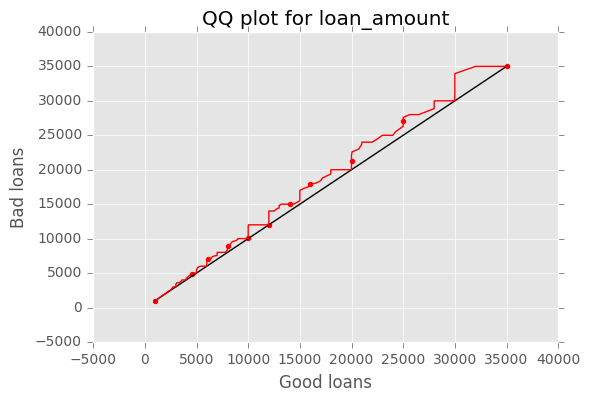

In [156]:
good_bad_quantile_plot(data, 'loan_amount')

In [157]:
# logistic regression
fit_and_score_one_model(data[['loan_amount']].values, data['loan_status'], log_reg)

Accuracy with logistic regression:
	Training: 0.2241
	Testing: 0.2241

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,207,"2,711"
1,Actual_good,39,588


F1 score =  0.299251067491


In [158]:
# random_forests
fit_and_score_one_model(data[['loan_amount']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.6944
	Testing: 0.6552

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"2,114",803
1,Actual_good,419,208


F1 score =  0.254179503213


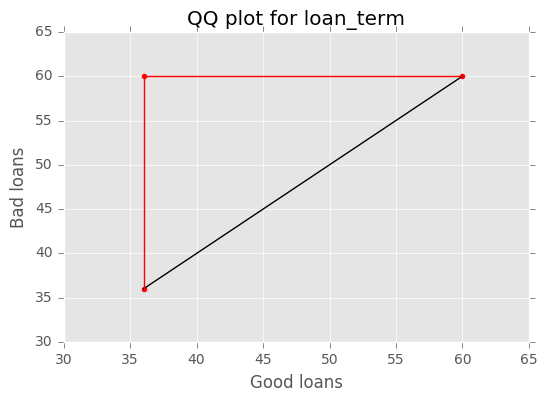

In [159]:
good_bad_quantile_plot(data, 'loan_term')

In [160]:
fit_and_score_one_model(data[['loan_term']].values, data['loan_status'], log_reg)

Accuracy with logistic regression:
	Training: 0.1768
	Testing: 0.1768

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,0,"2,917"
1,Actual_good,0,627


F1 score =  0.300344338218


In [161]:
# random_forests
fit_and_score_one_model(data[['loan_term']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.7264
	Testing: 0.7264

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"2,351",566
1,Actual_good,404,223


F1 score =  0.313377379002


In [162]:
# SVM
# fit_and_score_one_model(data[['loan_term']].values, data['loan_status'], svm)

In [163]:
# random_forests
fit_and_score_one_model(data[['loan_amount', 'dti', 'revol_util', 'rir', 
                             'annual_income', 'loan_term']].values, 
                        data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.9739
	Testing: 0.8008

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"2,792",125
1,Actual_good,581,46


F1 score =  0.115051411302


In [164]:
# SVM
# fit_and_score_one_model(data[['loan_amount']].values, data['loan_status'], svm)

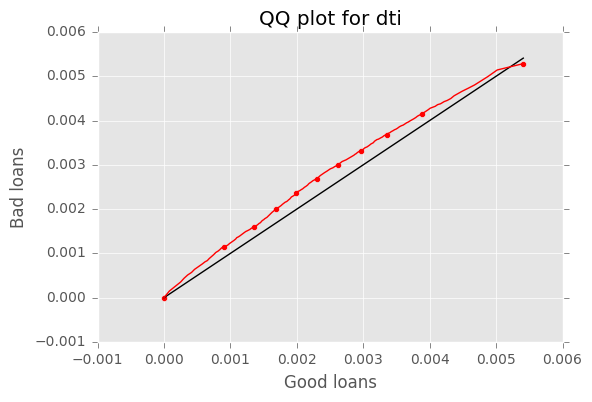

In [165]:
good_bad_quantile_plot(data, 'dti')

In [166]:
# random_forests
fit_and_score_one_model(data[['dti']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.8452
	Testing: 0.6963

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"2,316",601
1,Actual_good,475,151


F1 score =  0.218131329256


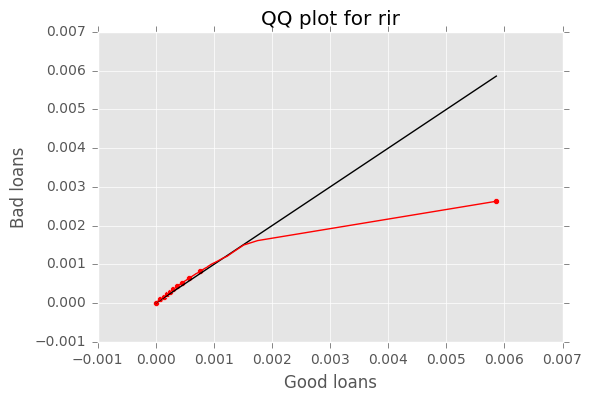

In [167]:
good_bad_quantile_plot(data, 'rir')

In [168]:
# random_forests
fit_and_score_one_model(data[['dti']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.8452
	Testing: 0.6963

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"2,316",601
1,Actual_good,475,151


F1 score =  0.218131329256


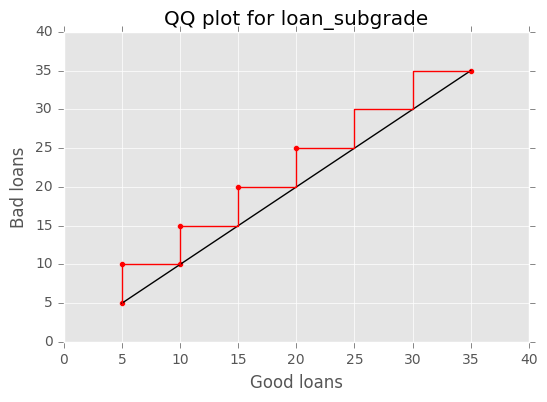

In [169]:
good_bad_quantile_plot(data, 'loan_subgrade')

In [170]:
# random_forests
fit_and_score_one_model(data[['loan_subgrade']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.5597
	Testing: 0.5597

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"1,520","1,397"
1,Actual_good,163,463


F1 score =  0.371893577713


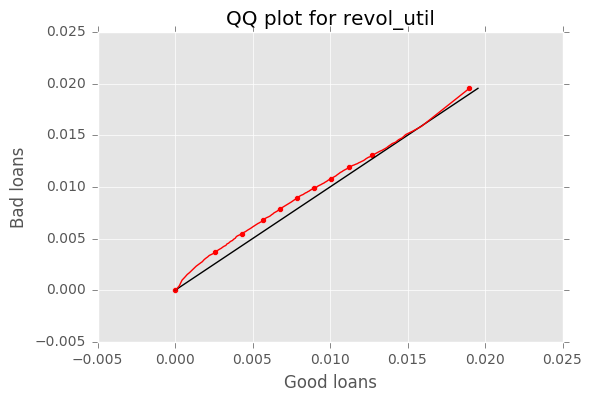

In [171]:
good_bad_quantile_plot(data, 'revol_util')

In [172]:
# random_forests
fit_and_score_one_model(data[['revol_util']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.8161
	Testing: 0.6726

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"2,229",688
1,Actual_good,472,155


F1 score =  0.21028856006


### Stacking

In [173]:
### extract predictors and response
def extract_predictors_response(x, y):
    mask = np.random.rand(x.shape[0]) < 0.8

    x_train = x[mask, :]
    x_test = x[~mask, :]

    y_train = y.values[mask]
    y_test = y.values[~mask]
    
    return x_train, y_train, x_test, y_test

In [174]:
# function to create model stack
def create_model_stack(x, y):
    model_stack = []

    # logistic regression
    model = get_model_instance(log_reg, y)
    model.fit(x, y)
    model_stack.append(model)

#     # QDA
#     model = get_model_instance(qda, y)
#     model.fit(x, y)
#     model_stack.append(model)

#     # KNN
#     model = get_model_instance(knn, y)
#     model.fit(x, y)
#     model_stack.append(model)

    # random forests
    model = get_model_instance(rf, y)
    model.fit(x, y)
    model_stack.append(model)

    # # boosting
    # model = get_model_instance(boost, y)
    # model.fit(x, y)
    # model_stack.append(model)

#     # SVM
#     model = get_model_instance(svm, y)
#     model.fit(x, y)
#     model_stack.append(model)
    
    return model_stack

In [175]:
# function to fit and score a stacking ensemble
def fit_score_stacking(models, x_train, y_train, x_test, y_test, combiner, combiner_name):
    n_train = x_train.shape[0]
    n_test = x_test.shape[0]
    num_models = len(models)
    
    # create variables to hold predictions
    y_train_stack = np.zeros((n_train, num_models))
    y_test_stack = np.zeros((n_test, num_models))
    y_predict = np.zeros(n_test)

    # predict with each model on training and testing data
    for index in range(num_models):
        model = models[index]
        y_train_stack[:, index] = model.predict(x_train)
        y_test_stack[:, index] = model.predict(x_test)

    # predict with ensemble
    combiner.fit(y_train_stack, y_train)
    y_predict = combiner.predict(y_test_stack)
    
    # score with ensemble
    score = combiner.score(y_test_stack, y_test)
    cm = confusion_matrix(y_test, y_predict)
    f1_result = f1_score(y_test, y_predict, pos_label = 1)
    
    # format confusion matrix
    cm_df = pd.DataFrame(cm, columns = ["Predicted_bad", "Predicted_good"])
    row_labels = pd.DataFrame(["Actual_bad", "Actual_good"])
    cm_df = pd.concat((row_labels, cm_df), axis = 1)

    return score, cm_df, f1_result

In [176]:
# fit and score a stacked model for given predictors and response
def try_one_stacked_model(x, y, combiner_type, combiner_name):

    x_train, y_train, x_test, y_test = extract_predictors_response(x, y)

    model_stack = create_model_stack(x_train, y_train)

    combiner = get_model_instance(combiner_type, y_train)

    score, cm_df, f1_result = fit_score_stacking(model_stack, x_train, y_train, 
                                                 x_test, y_test, combiner, combiner_name)

    print
    print "Accuracy with stacking by " + combiner_name + " = " + str(round(score, 4))
    print
    print "Confusion Matrix"
    display(cm_df)
    print
    print "F1 score with stacking by " + combiner_name + " = " + str(round(f1_result, 4))

In [177]:
# fit and score a stacked-model ensemble using NLP features
try_one_stacked_model(count_cols_bool, data_nlp['loan_status'], rf, "random forests")


Accuracy with stacking by random forests = 0.6756

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,773,243
1,Actual_good,155,56



F1 score with stacking by random forests = 0.2196


In [178]:
# fit and score a stacked-model ensemble using loan amount
try_one_stacked_model(data['loan_amount'].reshape(-1, 1), data['loan_status'], 
                      rf, "random forests")


Accuracy with stacking by random forests = 0.6402

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,2042,847
1,Actual_good,419,211



F1 score with stacking by random forests = 0.25


In [179]:
try_one_stacked_model(desc_matrix, data_nlp['loan_status'], rf, "random forests")


Accuracy with stacking by random forests = 0.7478

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,827,118
1,Actual_good,172,33



F1 score with stacking by random forests = 0.1854


In [180]:
nlp_base = np.concatenate((count_cols_bool, 
                           data_nlp[['loan_amount', 'annual_income', 'rir',
                                    'revol_util', 'dti', 'loan_term']]), axis = 1)
try_one_stacked_model(nlp_base, data_nlp['loan_status'], log_reg, "logistic regression")


Accuracy with stacking by logistic regression = 0.4859

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,426,561
1,Actual_good,57,158



F1 score with stacking by logistic regression = 0.3383
